In [1]:
import pickle
import copy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import blackjack as bj
from blackjack import Hand, HandScore, Action, make_hand
import simulator as sim
import optimizer as opt


In [2]:
h = HandScore(11, True)
h

s11

In [3]:
h.add_card(10)

s21

In [4]:
h.add_card(10).add_card(10)

h21

In [5]:
h

s11

In [6]:
h.add_card(3)

s14

In [7]:
h.add_card(3).add_card(10)

h14

In [8]:
all_scores = [HandScore(i, False) for i in range(0, 23)] + [HandScore(i, True) for i in range(11, 22)]
all_scores

[h00,
 h01,
 h02,
 h03,
 h04,
 h05,
 h06,
 h07,
 h08,
 h09,
 h10,
 h11,
 h12,
 h13,
 h14,
 h15,
 h16,
 h17,
 h18,
 h19,
 h20,
 h21,
 h22,
 s11,
 s12,
 s13,
 s14,
 s15,
 s16,
 s17,
 s18,
 s19,
 s20,
 s21]

In [9]:
h = Hand()
h

Hand(score=h00, cards=[], doubled=False, drawn=False, surrendered=False)

In [10]:
h.add_card(6) # start a hand with a 6

Hand(score=h06, cards=[6], doubled=False, drawn=False, surrendered=False)

In [11]:
h.add_card(11) # show that J (11) counts as 10 points

Hand(score=h16, cards=[6, 11], doubled=False, drawn=False, surrendered=False)

In [12]:
h.add_card(7), bj.is_busted(h) # bust (show that 23 is counted as 22)

(Hand(score=h22, cards=[6, 11, 7], doubled=False, drawn=False, surrendered=False),
 True)

In [13]:
# OK, now let's try another hand with aces
h = Hand()
h.add_card(1) # should be a soft 11

Hand(score=s11, cards=[1], doubled=False, drawn=False, surrendered=False)

In [14]:
h.add_card(1) # two aces: should be a soft 12

Hand(score=s12, cards=[1, 1], doubled=False, drawn=False, surrendered=False)

In [15]:
h.add_card(11) # two aces and a J: should be a hard 12

Hand(score=h12, cards=[1, 1, 11], doubled=False, drawn=False, surrendered=False)

In [16]:
# OK, now let's try another hand with a blackjack
h = Hand()
h.add_card(1) # should be a soft 11
h.add_card(10)
h, bj.is_blackjack(h)

(Hand(score=s21, cards=[1, 10], doubled=False, drawn=False, surrendered=False),
 True)

## Now define gameplay and strategy

In [17]:
shoe = bj.Shoe()
[shoe.deal() for _ in range(10)]

[1, 13, 5, 6, 11, 2, 7, 2, 13, 6]

In [18]:
bj.play_one_round([bj.strat_nobust, bj.strat_nobust])

[('strat_nobust_func',
  Hand(score=h20, cards=[11, 13], doubled=False, drawn=False, surrendered=False),
  Hand(score=h19, cards=[5, 6, 8], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.WIN: 1>),
 ('strat_nobust_func',
  Hand(score=h20, cards=[11, 13], doubled=False, drawn=False, surrendered=False),
  Hand(score=h19, cards=[5, 6, 8], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.WIN: 1>)]

In [19]:
# Test out the stateful shoe
cards = [shoe.deal() for _ in range(10)]
this_shoe = bj.StatefulShoe(cards)
this_shoe.cards

[10, 11, 1, 6, 13, 7, 3, 8, 6, 1]

In [20]:
this_shoe.deal(), this_shoe.cards

(1, [10, 11, 1, 6, 13, 7, 3, 8, 6])

In [21]:
s2 = copy.deepcopy(this_shoe)
s3 = copy.deepcopy(this_shoe)
s2.cards, s3.cards

([10, 11, 1, 6, 13, 7, 3, 8, 6], [10, 11, 1, 6, 13, 7, 3, 8, 6])

In [22]:
s2.deal(), s2.cards, s3.cards

(6, [10, 11, 1, 6, 13, 7, 3, 8], [10, 11, 1, 6, 13, 7, 3, 8, 6])

## Aggregate and summarize the data from the simulations

In [23]:


strat_nobust = bj.strat_nobust
strat_dealer = bj.strat_dealer
sim.generate_rows_from_round(bj.play_one_round([bj.strat_nobust, bj.strat_dealer]))


[{'strategy': 'strat_nobust_func',
  'hand_start': [3, 8],
  'dealer_card': 6,
  'hand_end': [3, 8, 8],
  'dealer_hand': [6, 8, 7],
  'outcome': <HandOutcome.LOSE: -1>},
 {'strategy': 'strat_dealer_func',
  'hand_start': [3, 8],
  'dealer_card': 6,
  'hand_end': [3, 8, 8],
  'dealer_hand': [6, 8, 7],
  'outcome': <HandOutcome.LOSE: -1>}]

In [24]:


sim_results = sim.run_n_sim_trials([strat_nobust, strat_dealer], 10000)
#%prun -s cumulative sim_results, sim.summarize_totals(sim_results)

In [25]:
def strat_simple_func(score_p, score_d):
    if score_p.points == 11:  return Action.DOUBLE
    if score_p.points >= 17:  return Action.STAND
    if score_p.points <= 11:  return Action.HIT
    if score_d.points in (range(3,7)):  return Action.STAND
    else:  return Action.HIT
        
strat_simple_func.name = 'simple'

strat_simple = bj.Strategy_wrapper(strat_simple_func)
sims = sim.run_n_sim_trials([strat_simple], 1000)
sims.head(10), sim.summarize_totals(sims)

(            strategy hand_start  dealer_card     hand_end     dealer_hand  \
 0  strat_simple_func   [12, 11]            3     [12, 11]       [3, 9, 7]   
 1  strat_simple_func   [11, 12]           10     [11, 12]         [10, 1]   
 2  strat_simple_func   [13, 13]            5     [13, 13]       [5, 3, 9]   
 3  strat_simple_func     [1, 3]            5       [1, 3]      [5, 11, 5]   
 4  strat_simple_func     [8, 2]            8   [8, 2, 13]       [8, 7, 6]   
 5  strat_simple_func    [6, 13]            2  [6, 13, 11]  [2, 11, 2, 11]   
 6  strat_simple_func   [10, 12]            3     [10, 12]   [3, 2, 5, 10]   
 7  strat_simple_func    [9, 11]            4      [9, 11]       [4, 5, 9]   
 8  strat_simple_func    [11, 5]            8   [11, 5, 8]      [8, 7, 11]   
 9  strat_simple_func     [9, 6]            8    [9, 6, 7]         [8, 12]   
 
             outcome  outcome_value outcome_name  
 0   HandOutcome.WIN            1.0          WIN  
 1  HandOutcome.LOSE           -1.0   

In [26]:
%prun -s cumulative sim.summarize_totals(sim.run_n_sim_trials([strat_dealer, strat_nobust, strat_simple], 10))


         30395 function calls (29969 primitive calls) in 0.014 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.015    0.015 {built-in method builtins.exec}
        1    0.000    0.000    0.014    0.014 <string>:1(<module>)
        1    0.000    0.000    0.011    0.011 simulator.py:30(summarize_totals)
      3/1    0.000    0.000    0.004    0.004 generic.py:223(aggregate)
        1    0.000    0.000    0.004    0.004 generic.py:281(_aggregate_multiple_funcs)
        1    0.000    0.000    0.003    0.003 simulator.py:18(run_n_sim_trials)
        2    0.000    0.000    0.003    0.001 groupby.py:1157(_python_agg_general)
    54/25    0.000    0.000    0.002    0.000 base.py:250(__new__)
        8    0.000    0.000    0.002    0.000 frame.py:502(__init__)
        5    0.000    0.000    0.002    0.000 managers.py:1176(insert)
        6    0.000    0.000    0.002    0.000 frame.py:3147(__setitem

## Simulate specific situations to determine strategy

In [27]:
# 12 vs deuce

hand_p = make_hand([5, 7])
hand_d = make_hand([2])

hand_p, hand_d

(Hand(score=h12, cards=[5, 7], doubled=False, drawn=False, surrendered=False),
 Hand(score=h02, cards=[2], doubled=False, drawn=False, surrendered=False))

In [28]:
# Implement a strategy that composes conditions and actions

def cond_12_2(score_p, score_d):
    return score_p.points == 12 and score_d.points == 2 and not score_p.soft
conditions = [(cond_12_2, Action.STAND)]


    
strat_cond = sim.generate_strat_conditional(strat_simple, conditions)
strat_cond

strat_cond

In [29]:
# Generate a conditional strategy for each action
    
strats = sim.gen_cond_strategies(strat_simple, cond_12_2, Action)
strats

[<Action.SURRENDER: 1>, <Action.STAND: 2>, <Action.HIT: 3>, <Action.DOUBLE: 4>]

In [30]:
bj.complete_one_round(strats, hand_p, hand_d, bj.Shoe().deal(), bj.Shoe())

[('<Action.SURRENDER: 1>',
  Hand(score=h12, cards=[5, 7], doubled=False, drawn=False, surrendered=True),
  Hand(score=h19, cards=[2, 1, 7, 9], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.SURRENDER: -0.5>),
 ('<Action.STAND: 2>',
  Hand(score=h12, cards=[5, 7], doubled=False, drawn=False, surrendered=False),
  Hand(score=h19, cards=[2, 1, 7, 9], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.LOSE: -1>),
 ('<Action.HIT: 3>',
  Hand(score=h18, cards=[5, 7, 6], doubled=False, drawn=True, surrendered=False),
  Hand(score=h19, cards=[2, 1, 7, 9], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.LOSE: -1>),
 ('<Action.DOUBLE: 4>',
  Hand(score=h18, cards=[5, 7, 6], doubled=True, drawn=True, surrendered=False),
  Hand(score=h19, cards=[2, 1, 7, 9], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.LOSE_DOUBLE: -2>)]

In [31]:


sims = sim.run_n_sim_trials(strats, 10000, (hand_p, hand_d))
sim.summarize_totals(sims)

len                                              \
outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
strategy                                                                  
<Action.DOUBLE: 4>        0        5985  478         0     0       3537   
<Action.HIT: 3>        6120           0  653         0  3227          0   
<Action.STAND: 2>      6368           0    0         0  3632          0   
<Action.SURRENDER: 1>     0           0    0     10000     0          0   

                      mean_outcome  
outcome_name                        
strategy                            
<Action.DOUBLE: 4>         -0.4896  
<Action.HIT: 3>            -0.2893  
<Action.STAND: 2>          -0.2736  
<Action.SURRENDER: 1>      -0.5000

In [32]:
# Soft 12 vs 2
hand_12s = make_hand([1, 1])

hand_12s, hand_d

(Hand(score=s12, cards=[1, 1], doubled=False, drawn=False, surrendered=False),
 Hand(score=h02, cards=[2], doubled=False, drawn=False, surrendered=False))

In [33]:
def cond_12s_2(score_p, score_d):
    return score_p == HandScore(12, True) and score_d.points == 2

strats = sim.gen_cond_strategies(strat_simple, cond_12s_2, Action)
strats

[<Action.SURRENDER: 1>, <Action.STAND: 2>, <Action.HIT: 3>, <Action.DOUBLE: 4>]

In [34]:
sims = sim.run_n_sim_trials(strats+[strat_simple], 10000, (hand_12s, hand_d))
sim.summarize_totals(sims)

len                                              \
outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
strategy                                                                  
<Action.DOUBLE: 4>        0        6365    0         0     0       3635   
<Action.HIT: 3>        5271           0  817         0  3912          0   
<Action.STAND: 2>      6365           0    0         0  3635          0   
<Action.SURRENDER: 1>     0           0    0     10000     0          0   
strat_simple_func      5271           0  817         0  3912          0   

                      mean_outcome  
outcome_name                        
strategy                            
<Action.DOUBLE: 4>         -0.5460  
<Action.HIT: 3>            -0.1359  
<Action.STAND: 2>          -0.2730  
<Action.SURRENDER: 1>      -0.5000  
strat_simple_func          -0.1359

In [35]:
sim.summarize_totals(sim.run_n_sim_trials([strat_simple, strat_cond], 10*1000,  (hand_p, hand_d)))

len            mean_outcome
outcome_name       LOSE PUSH   WIN             
strategy                                       
strat_cond         6396    0  3604      -0.2792
strat_simple_func  6035  680  3285      -0.2750

In [36]:
# soft 13 vs 6
def cond_13s_6(score_p, score_d):
    return score_p == HandScore(13, True) and score_d.points == 6



strats = sim.gen_cond_strategies(strat_simple, cond_13s_6, Action)
sims = sim.run_n_sim_trials(strats+[strat_simple], 10000, (bj.make_hand([1, 2]), bj.make_hand([6])))
sim.summarize_totals(sims)

len                                              \
outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
strategy                                                                  
<Action.DOUBLE: 4>        0        5778    0         0     0       4222   
<Action.HIT: 3>        4844           0  324         0  4832          0   
<Action.STAND: 2>      5778           0    0         0  4222          0   
<Action.SURRENDER: 1>     0           0    0     10000     0          0   
strat_simple_func      5778           0    0         0  4222          0   

                      mean_outcome  
outcome_name                        
strategy                            
<Action.DOUBLE: 4>         -0.3112  
<Action.HIT: 3>            -0.0012  
<Action.STAND: 2>          -0.1556  
<Action.SURRENDER: 1>      -0.5000  
strat_simple_func          -0.1556

In [37]:
# 10 v 6
def cond_10_6(score_p, score_d):
    return score_p.points == 10 and score_d.points == 6

strats = sim.gen_cond_strategies(strat_simple, cond_10_6, Action)
sims = sim.run_n_sim_trials(strats+[strat_simple], 10000, (make_hand([5, 5]), make_hand([6])))
sim.summarize_totals(sims)

len                                              \
outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
strategy                                                                  
<Action.DOUBLE: 4>        0        3223  656         0     0       6121   
<Action.HIT: 3>        3223           0  656         0  6121          0   
<Action.STAND: 2>      5804           0    0         0  4196          0   
<Action.SURRENDER: 1>     0           0    0     10000     0          0   
strat_simple_func      3223           0  656         0  6121          0   

                      mean_outcome  
outcome_name                        
strategy                            
<Action.DOUBLE: 4>          0.5796  
<Action.HIT: 3>             0.2898  
<Action.STAND: 2>          -0.1608  
<Action.SURRENDER: 1>      -0.5000  
strat_simple_func           0.2898

In [38]:
sim.test_cond(HandScore(10), HandScore(6), 10000, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                         len                                              \
 outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
 strategy                                                                  
 <Action.DOUBLE: 4>        0        3225  708         0     0       6067   
 <Action.HIT: 3>        3225           0  708         0  6067          0   
 <Action.STAND: 2>      5770           0    0         0  4230          0   
 <Action.SURRENDER: 1>     0           0    0     10000     0          0   
 
                       mean_outcome  
 outcome_name                        
 strategy                            
 <Action.DOUBLE: 4>          0.5684  
 <Action.HIT: 3>             0.2842  
 <Action.STAND: 2>          -0.1540  
 <Action.SURRENDER: 1>      -0.5000  )

In [39]:
sim.test_cond(HandScore(18), HandScore(6), 200, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                        len                                             \
 outcome_name          LOSE LOSE_DOUBLE PUSH SURRENDER  WIN WIN_DOUBLE   
 strategy                                                                
 <Action.DOUBLE: 4>       0         167    6         0    0         27   
 <Action.HIT: 3>        167           0    6         0   27          0   
 <Action.STAND: 2>       57           0   15         0  128          0   
 <Action.SURRENDER: 1>    0           0    0       200    0          0   
 
                       mean_outcome  
 outcome_name                        
 strategy                            
 <Action.DOUBLE: 4>          -1.400  
 <Action.HIT: 3>             -0.700  
 <Action.STAND: 2>            0.355  
 <Action.SURRENDER: 1>       -0.500  )

In [40]:
sim.test_cond(HandScore(21, True), HandScore(6), 200, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                             len                                        \
 outcome_name          BLACKJACK LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE   
 strategy                                                                
 <Action.DOUBLE: 4>            0    0          78   14    0        108   
 <Action.HIT: 3>               0   78           0   14  108          0   
 <Action.STAND: 2>           200    0           0    0    0          0   
 <Action.SURRENDER: 1>       200    0           0    0    0          0   
 
                       mean_outcome  
 outcome_name                        
 strategy                            
 <Action.DOUBLE: 4>            0.30  
 <Action.HIT: 3>               0.15  
 <Action.STAND: 2>             1.50  
 <Action.SURRENDER: 1>         1.50  )

In [41]:

sim.find_winning_action(HandScore(10), HandScore(6), 200)

{'<Action.DOUBLE: 4>': 0.45,
 '<Action.HIT: 3>': 0.225,
 '<Action.STAND: 2>': -0.24,
 '<Action.SURRENDER: 1>': -0.5,
 'score_p': 'h10',
 'score_d': 'h06',
 'winning_act': <Action.DOUBLE: 4>,
 'winning_act_outcome': 0.45}

In [42]:
sim.test_cond(HandScore(18), HandScore(11, True), 1000)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                        len                                             \
 outcome_name          LOSE LOSE_DOUBLE PUSH SURRENDER  WIN WIN_DOUBLE   
 strategy                                                                
 <Action.DOUBLE: 4>       0         858   13         0    0        129   
 <Action.HIT: 3>        858           0   13         0  129          0   
 <Action.STAND: 2>      567           0  144         0  289          0   
 <Action.SURRENDER: 1>  275           0    0       725    0          0   
 
                       mean_outcome  
 outcome_name                        
 strategy                            
 <Action.DOUBLE: 4>         -1.4580  
 <Action.HIT: 3>            -0.7290  
 <Action.STAND: 2>          -0.2780  
 <Action.SURRENDER: 1>      -0.6375  )

In [43]:
%prun -s cumulative conds = sim.compute_instructions(20)
pd.DataFrame(conds).set_index(['score_p', 'score_d'])

<Action.DOUBLE: 4>  <Action.HIT: 3>  <Action.STAND: 2>  \
score_p score_d                                                           
h09     s11                    -1.0            -0.25             -0.800   
        h02                    -0.6            -0.40             -0.600   
        h03                    -0.3            -0.15             -0.400   
        h04                     0.4             0.20             -0.100   
        h05                     0.7             0.35              0.100   
...                             ...              ...                ...   
s21     h06                     1.2             0.60              1.500   
        h07                     0.1             0.25              1.500   
        h08                    -0.2            -0.10              1.500   
        h09                     0.1            -0.05              1.500   
        h10                     0.3             0.15              1.425   

                 <Action.SURRENDER: 1>    winning_act  winning_act_outcome  
score_p score_d                                                             
h09     s11                     -0.675     Action.HIT               -0.250  
        h02                     -0.500     Action.HIT               -0.400  
        h03                     -0.500     Action.HIT               -0.150  
        h04                     -0.500  Action.DOUBLE                0.400  
        h05                     -0.500  Action.DOUBLE                0.700  
...                                ...            ...                  ...  
s21     h06                      1.500   Action.STAND                1.500  
        h07                      1.500   Action.STAND                1.500  
        h08                      1.500   Action.STAND                1.500  
        h09                      1.500   Action.STAND                1.500  
        h10                      1.425   Action.STAND                1.425  

[250 rows x 6 columns]

         10303050 function calls (10141198 primitive calls) in 4.080 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    4.084    4.084 {built-in method builtins.exec}
        1    0.000    0.000    4.084    4.084 <string>:1(<module>)
        1    0.000    0.000    4.084    4.084 simulator.py:96(compute_instructions)
        1    0.003    0.003    4.084    4.084 simulator.py:98(<listcomp>)
      250    0.006    0.000    4.080    0.016 simulator.py:80(find_winning_action)
      250    0.003    0.000    3.649    0.015 simulator.py:71(test_cond)
      250    0.014    0.000    2.769    0.011 simulator.py:30(summarize_totals)
      250    0.003    0.000    0.871    0.003 simulator.py:18(run_n_sim_trials)
  750/250    0.003    0.000    0.809    0.003 generic.py:223(aggregate)
      250    0.003    0.000    0.805    0.003 generic.py:281(_aggregate_multiple_funcs)
5518/5268    0.015    0.000    0.648   

In [44]:

%prun -s cumulative sim.compute_instructions(100, strat_simple)

         16370801 function calls (16007842 primitive calls) in 5.924 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    5.945    5.945 {built-in method builtins.exec}
        1    0.000    0.000    5.945    5.945 <string>:1(<module>)
        1    0.000    0.000    5.945    5.945 simulator.py:96(compute_instructions)
        1    0.003    0.003    5.945    5.945 simulator.py:98(<listcomp>)
      250    0.012    0.000    5.940    0.024 simulator.py:80(find_winning_action)
      250    0.008    0.000    5.491    0.022 simulator.py:71(test_cond)
      250    0.016    0.000    2.873    0.011 simulator.py:30(summarize_totals)
      250    0.005    0.000    2.606    0.010 simulator.py:18(run_n_sim_trials)
      250    0.035    0.000    1.911    0.008 simulator.py:21(<listcomp>)
    25000    0.055    0.000    1.778    0.000 blackjack.py:244(complete_one_round)
    25000    0.073    0.000    0.952    0.

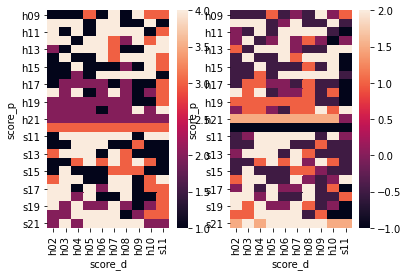

         8552181 function calls (8444783 primitive calls) in 3.675 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.676    3.676 {built-in method builtins.exec}
        1    0.000    0.000    3.676    3.676 <string>:1(<module>)
        1    0.000    0.000    3.676    3.676 optimizer.py:8(run_iteration)
        1    0.000    0.000    3.403    3.403 simulator.py:96(compute_instructions)
        1    0.003    0.003    3.403    3.403 simulator.py:98(<listcomp>)
      250    0.006    0.000    3.398    0.014 simulator.py:80(find_winning_action)
      250    0.003    0.000    2.961    0.012 simulator.py:71(test_cond)
      250    0.013    0.000    2.485    0.010 simulator.py:30(summarize_totals)
  750/250    0.004    0.000    0.779    0.003 generic.py:223(aggregate)
      250    0.003    0.000    0.775    0.003 generic.py:281(_aggregate_multiple_funcs)
14874/6709    0.117    0.000    0.592    0.00

In [45]:


%prun -s cumulative opt.run_iteration(1, strat_simple, None)

In [46]:
# Memoized strategy
# Rather than generic conditions, just use an array indexed on player and dealer scores
# Since that's how we're generating our strategy anyway (one square at a time)

instructions = {(repr(HandScore(13, True)), repr(HandScore(6))): Action.HIT}
strat_memoized = opt.gen_strat_memoized(instructions, strat_simple)

sims = sim.run_n_sim_trials([strat_simple, strat_memoized], 1000)
sims.head(10), sim.summarize_totals(sims)

(            strategy hand_start  dealer_card          hand_end dealer_hand  \
 0  strat_simple_func     [6, 4]            1        [6, 4, 11]     [1, 13]   
 1           memoized     [6, 4]            1        [6, 4, 11]     [1, 13]   
 2  strat_simple_func    [12, 8]            9           [12, 8]     [9, 13]   
 3           memoized    [12, 8]            9           [12, 8]     [9, 13]   
 4  strat_simple_func     [2, 3]            2  [2, 3, 13, 1, 4]   [2, 9, 9]   
 5           memoized     [2, 3]            2  [2, 3, 13, 1, 4]   [2, 9, 9]   
 6  strat_simple_func    [4, 13]            1       [4, 13, 11]     [1, 12]   
 7           memoized    [4, 13]            1       [4, 13, 11]     [1, 12]   
 8  strat_simple_func    [11, 9]           12           [11, 9]  [12, 6, 1]   
 9           memoized    [11, 9]           12           [11, 9]  [12, 6, 1]   
 
             outcome  outcome_value outcome_name  
 0  HandOutcome.LOSE           -1.0         LOSE  
 1  HandOutcome.LOSE       

In [47]:


strategies = opt.derive_iterative_strategies(strat_simple, 7)
strategies

Starting iteration 0
Starting iteration 1
('h09', 'h02') Action.DOUBLE Action.HIT
('h09', 'h05') Action.DOUBLE Action.HIT
('h10', 'h06') Action.DOUBLE Action.HIT
('h10', 'h09') Action.DOUBLE Action.HIT
('h10', 'h10') Action.HIT Action.DOUBLE
('h11', 'h08') Action.HIT Action.DOUBLE
('h12', 'h03') Action.HIT Action.STAND
('h12', 'h04') Action.HIT Action.STAND
('h12', 'h06') Action.HIT Action.STAND
('h12', 'h10') Action.HIT Action.SURRENDER
('h13', 's11') Action.STAND Action.HIT
('h13', 'h02') Action.HIT Action.STAND
('h13', 'h10') Action.HIT Action.STAND
('h14', 's11') Action.SURRENDER Action.HIT
('h14', 'h03') Action.STAND Action.DOUBLE
('h14', 'h06') Action.HIT Action.STAND
('h14', 'h07') Action.HIT Action.STAND
('h14', 'h09') Action.HIT Action.STAND
('h14', 'h10') Action.STAND Action.HIT
('h15', 'h03') Action.STAND Action.HIT
('h15', 'h04') Action.STAND Action.HIT
('h15', 'h08') Action.HIT Action.STAND
('h15', 'h09') Action.SURRENDER Action.HIT
('h15', 'h10') Action.STAND Action.HIT
(

In [ ]:
with open('strategies.pickle', 'wb') as handle:
    pickle.dump(strategies, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
sims = sim.run_n_sim_trials(strategies, 1000*1000)
sims.head(10), sim.summarize_totals(sims)

In [ ]:
sim.summarize_totals(sims)